In [1]:
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco200/bin:/usr/lib/nvidia:$CONDA_PREFIX/lib
# export PATH=$PATH:$CONDA_PREFIX/bin
# export CUDA_VISIBLE_DEVICES=0
# export GPUS=0

In [2]:
import copy
import functools

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import jax
import optax
import numpy as np
import tensorflow as tf

from acme import specs
from acme.tf.savers import SaveableAdapter

import contrastive
from contrastive.config import ContrastiveConfig
from contrastive import utils as contrastive_utils
from contrastive import make_networks
from contrastive.utils import make_environment
from contrastive import ContrastiveLearner

# disable tensorflow_probability warning: The use of `check_types` is deprecated and does not have any effect.
import logging
logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

2024-07-22 11:42:44.957924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yongweic/.conda/envs/contrastive_rl/lib:/home/yongweic/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/yongweic/.mujoco/mujoco200/bin:/home/yongweic/.mujoco/mujoco200/bin
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:52:03
/home/yongweic/.conda/envs/contrastive_rl/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
env_name = 'offline_ant_umaze'

params = {
  'use_random_actor': True,
  'entropy_coefficient': None if 'image' in env_name else 0.0,
  'env_name': env_name,
  # For online RL experiments, max_number_of_steps is the number of
  # environment steps. For offline RL experiments, this is the number of
  # gradient steps.
  'max_number_of_steps': 1_000_000,
  'use_image_obs': 'image' in env_name,
}
if 'ant_' in env_name:
    params['end_index'] = 2

# 2. Select an algorithm. The currently-supported algorithms are:
# contrastive_nce, contrastive_cpc, c_learning, nce+c_learning, gcbc.
# Many other algorithms can be implemented by passing other parameters
# or adding a few lines of code.
alg = 'contrastive_nce'
if alg == 'contrastive_nce':
    pass  # Just use the default hyperparameters
elif alg == 'contrastive_cpc':
    params['use_cpc'] = True
elif alg == 'c_learning':
    params['use_td'] = True
    params['twin_q'] = True
elif alg == 'nce+c_learning':
    params['use_td'] = True
    params['twin_q'] = True
    params['add_mc_to_td'] = True
elif alg == 'gcbc':
    params['use_gcbc'] = True
else:
    raise NotImplementedError('Unknown method: %s' % alg)

# For the offline RL experiments, modify some hyperparameters.
if env_name.startswith('offline_ant'):
    params.update({
        # Effectively remove the rate-limiter by using very large values.
        'samples_per_insert': 1_000_000,
        'samples_per_insert_tolerance_rate': 100_000_000.0,
        # For the actor update, only use future states as goals.
        'random_goals': 0.0,
        'bc_coef': 0.05,  # Add a behavioral cloning term to the actor.
        'twin_q': True,  # Learn two critics, and take the minimum.
        'batch_size': 1024,  # Increase the batch size 256 --> 1024.
        'repr_dim': 16,  # Decrease the representation size 64 --> 16.
        # Increase the policy network size (256, 256) --> (1024, 1024)
        'hidden_layer_sizes': (1024, 1024),
    })
    print('hi')
    
print(params)
config = ContrastiveConfig(**params)

hi
{'use_random_actor': True, 'entropy_coefficient': 0.0, 'env_name': 'offline_ant_umaze', 'max_number_of_steps': 1000000, 'use_image_obs': False, 'end_index': 2, 'samples_per_insert': 1000000, 'samples_per_insert_tolerance_rate': 100000000.0, 'random_goals': 0.0, 'bc_coef': 0.05, 'twin_q': True, 'batch_size': 1024, 'repr_dim': 16, 'hidden_layer_sizes': (1024, 1024)}


In [4]:
env_name = "offline_ant_umaze"
ckpt_dir = "/home/yongweic/acme/911eecd6-4605-11ef-a1a8-70b5e8f063a8/checkpoints/learner"

config.critic_learning_rate = 0.001

obs_dim = make_environment(env_name, config.start_index, config.end_index, seed=0)[1]
# print(config.twin_q)
network_factory = functools.partial(
  contrastive.make_networks, 
    obs_dim=obs_dim, 
    repr_dim=config.repr_dim,
  repr_norm=config.repr_norm, 
    twin_q=config.twin_q,
  use_image_obs=config.use_image_obs,
  hidden_layer_sizes=config.hidden_layer_sizes)

# print(network_factory)

env_factory = lambda seed: make_environment(
  env_name, config.start_index, config.end_index, seed)[0]
dummy_seed = 1
environment_spec = specs.make_environment_spec(
    env_factory(dummy_seed))

print(environment_spec)

random_key = jax.random.PRNGKey(np.random.choice(int(1e6)))
networks = network_factory(environment_spec, 
                           obs_dim = obs_dim,
                           twin_q=config.twin_q,
                           hidden_layer_sizes = (1024, 1024)
                          )
policy_optimizer = optax.adam(
  learning_rate=config.actor_learning_rate)
q_optimizer = optax.adam(
  learning_rate=config.critic_learning_rate)
print(f'networks: {networks}')

trained_learner = ContrastiveLearner(
  networks=networks,
  rng=random_key,
  policy_optimizer=policy_optimizer,
  q_optimizer=q_optimizer,
  iterator=None,
  counter=None,
  logger=None,
  config=config,
  obs_to_goal=None
)

ckpt = tf.train.Checkpoint(learner=SaveableAdapter(trained_learner))
ckpt_mgr = tf.train.CheckpointManager(
    ckpt, ckpt_dir, 1)
ckpt.restore(ckpt_mgr.latest_checkpoint)

trained_learner_state = trained_learner._state

print("Model loaded from: {}".format(ckpt_dir))

print(trained_learner_state.policy_params['mlp/~/linear_0']['w'].shape)

Target Goal:  (0.8501951919631467, 8.987630957870868)
Target Goal:  (0.41707919211124644, 8.871490779758078)
EnvironmentSpec(observations=BoundedArray(shape=(31,), dtype=dtype('float32'), name='state', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]), actions=BoundedArray(shape=(8,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1.]), rewards=Array(shape=(), dtype=dtype('float64'), name='reward'), discounts=BoundedArray(shape=(), dtype=dtype('float64'), name='discount', minimum=0.0, maximum=1.0))


/home/yongweic/.conda/envs/contrastive_rl/lib/python3.9/site-packages/acme/jax/utils.py:73: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax.tree_map(lambda x: jnp.zeros(x.shape, dtype or x.dtype), nest)


networks: ContrastiveNetworks(policy_network=FeedForwardNetwork(init=<function make_networks.<locals>.<lambda> at 0x154e680e5d30>, apply=<function without_apply_rng.<locals>.apply_fn at 0x154e680e5280>), q_network=FeedForwardNetwork(init=<function make_networks.<locals>.<lambda> at 0x154e680f65e0>, apply=<function without_apply_rng.<locals>.apply_fn at 0x154e680e55e0>), l_network=FeedForwardNetwork(init=<function make_networks.<locals>.<lambda> at 0x154e680f6940>, apply=<function without_apply_rng.<locals>.apply_fn at 0x154e680e5940>), log_prob=<function make_networks.<locals>.<lambda> at 0x154e680f6790>, repr_fn=<function without_apply_rng.<locals>.apply_fn at 0x154e680e5ca0>, sample=<function make_networks.<locals>.<lambda> at 0x154e680f68b0>, sample_eval=<function make_networks.<locals>.<lambda> at 0x154e680f6820>)


2024-07-22 11:48:43.203003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yongweic/.conda/envs/contrastive_rl/lib:/home/yongweic/.mujoco/mujoco210/bin:/usr/lib/nvidia:/home/yongweic/.mujoco/mujoco200/bin:/home/yongweic/.mujoco/mujoco200/bin
2024-07-22 11:48:43.203081: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Model loaded from: /home/yongweic/acme/911eecd6-4605-11ef-a1a8-70b5e8f063a8/checkpoints/learner
(31, 1024)


In [5]:
trained_learner_state.q_params['g_encoder/~/linear_0']

{'b': Array([-0.12655969, -0.56473637, -0.01483181, ..., -0.03469238,
        -0.4838127 ,  0.02198083], dtype=float32),
 'w': Array([[-0.11976356, -0.33864626, -0.07944538, ...,  0.00242042,
          0.05714555, -0.10627162],
        [-0.00212874,  0.07671527, -0.05722534, ..., -0.00608215,
          0.0194293 , -0.07812383]], dtype=float32)}

In [6]:
env_factory = lambda seed: make_environment(
  env_name, config.start_index, config.end_index, seed)[0]

env = env_factory(np.random.randint(1e6))
# print(env.render(mode='rgb_array'))
obs = env.render(mode='rgb_array')

obs = np.zeros((1,29))
# plt.imshow(obs)
# print(obs)
action = np.random.normal(0, 1, env.action_space.shape)[None,:]
print(action.shape)

q_params = trained_learner_state.q_params

sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=env.reset().observation[None,:], action=action)

g_repr @ sa_repr.T

Target Goal:  (1.0287784054657694, 8.468583818324639)
(1, 8)
Target Goal:  (0.42841488053342264, 9.014577015548358)


Array([[-7.9160004]], dtype=float32)

In [26]:
obs = env.reset().observation

dist = networks.policy_network.apply(
      trained_learner_state.policy_params,
      obs
    ).mode()

action = dist[None,:]

sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=env.reset().observation[None,:], action=action)
print(f'optimal action: {sa_repr @ g_repr.T}')

sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=env.reset().observation[None,:], action=np.zeros((1, 8)))
print(f'random action: {sa_repr @ g_repr.T}')

Target Goal:  (0.7401725823483498, 8.558513445377164)
Target Goal:  (1.0987118508444573, 8.693238219280568)
optimal action: [[-8.216307]]
Target Goal:  (0.9586560642658, 8.974694362659758)
random action: [[-9.069131]]


In [8]:
networks.q_network.apply(q_params, obs=env.reset().observation[None,:], action=action)

Target Goal:  (0.9426631527311999, 9.293552857006825)


Array([[[-9.270743, -8.636176]]], dtype=float32)

In [25]:
env.action_space

Box(-1.0, 1.0, (8,), float32)

In [22]:
obs = env.reset()

env.unwrapped

Target Goal:  (0.6251578207847457, 8.744112090058989)


In [ ]:
env.sim.get_state()

In [27]:
networks.q_network.apply(q_params, obs=env.reset().observation[None,:], action=action)

Target Goal:  (0.6266237548841666, 8.792448125884365)


Array([[[-8.111514, -8.426245]]], dtype=float32)

In [28]:
dist = networks.policy_network.apply(
      trained_learner_state.policy_params,
      timestep.observation
    )

NameError: name 'timestep' is not defined

In [32]:
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 1024
NUM_EPISODES = 1

env = env_factory(np.random.randint(1e6))
obs_dim = env.observation_spec().shape[0] // 2
env.sim.model.geom_rgba[1:5] = 0  # Hide the lasers
imgs = np.zeros([NUM_EPISODES, env._step_limit, IMAGE_HEIGHT, IMAGE_WIDTH, 3], dtype=np.uint8)
episode_returns = np.zeros([NUM_EPISODES, ])


timesteps = []
for epi in range(NUM_EPISODES):
  t = 0
  env.seed(epi)  # use fixed seed for different methods
  timestep = env.reset()
  episode_return = 0

  while not timestep.last():
    # render images
    img = env.render(mode='rgb_array', height=IMAGE_HEIGHT, width=IMAGE_WIDTH)
    # # add a border if success
    # img = Image.fromarray(img)
    # orig_size = img.size
    # border = (8, 8, 8, 8)
    # if episode_return >= 1:
    #   img = ImageOps.expand(img, border=border, fill="#008000")
    # else:
    #   img = ImageOps.expand(img, border=border, fill="#FF3131")
    # img = img.resize(orig_size)
    # img = np.array(img)
    imgs[epi, t] = img

    # Generate an action from the agent's policy and step the environment.
    # if episode_return >= 1:
    #   action = np.zeros_like(env.action_space.shape)
    # else:
    #   dist = networks.policy_network.apply(
    #       trained_learner_state.policy_params,
    #       timestep.observation
    #   )
    #   action = np.array(dist.mode())
    dist = networks.policy_network.apply(
      trained_learner_state.policy_params,
      timestep.observation
    )
    action = np.array(dist.mode())
    timestep = env.step(action)
    timesteps.append(timestep)

    # Book-keeping.
    t += 1
    episode_return += timestep.reward

  # assert t == env._step_limit
  print("episode length = {}".format(t))
  episode_returns[epi] = episode_return

imgs = imgs.reshape([-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
print("avg episode return: {}".format(np.mean(episode_returns)))
print("success rate: {}".format(np.mean(episode_returns >= 1)))

imgs = imgs[:100]

Target Goal:  (1.098406507452637, 8.827523244580568)
Target Goal:  (1.1019649714643116, 8.478831532089655)
episode length = 144
avg episode return: 1.0
success rate: 1.0


In [36]:
timesteps[0]

TimeStep(step_type=<StepType.MID: 1>, reward=array(0.), discount=1.0, observation=array([ 5.37903792e-02, -1.85115748e-02,  7.85423570e-01,  9.89051477e-01,
        9.02871088e-02, -8.92365227e-02,  7.52479668e-02, -6.94957108e-02,
        4.76566763e-01, -8.64791210e-02, -4.73030004e-01,  2.30261461e-01,
       -3.85560507e-01,  7.56884695e-02,  4.41144543e-01, -3.90015766e-01,
       -6.96861007e-02, -7.37239661e-01,  3.71608097e-01,  1.69271170e-01,
        3.39290173e-03, -2.83178101e+00,  6.23208608e+00, -2.68061660e+00,
       -6.35716573e+00,  2.82062609e+00, -2.76891672e+00,  2.77131336e+00,
        5.34961875e+00,  1.10196497e+00,  8.47883153e+00]))

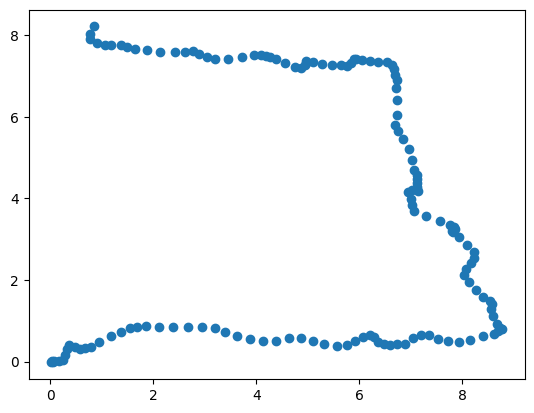

In [40]:
points = []
for timestep in timesteps:
    points.append(timestep.observation[:2])
    
points = np.array(points)
plt.scatter(points[:,0], points[:,1])

In [53]:
env_name = 'offline_ant_umaze_diverse'

env_factory = lambda seed: make_environment(
  env_name, config.start_index, config.end_index, seed)[0]

env = env_factory(np.random.randint(1e6))

env.env.env.spec

Target Goal:  (0.8724336625644329, 8.914668724571504)


EnvSpec(entry_point='d4rl.locomotion.ant:make_ant_maze_env', reward_threshold=None, nondeterministic=False, max_episode_steps=700, order_enforce=True, kwargs={'maze_map': [[1, 1, 1, 1, 1], [1, 'r', 0, 0, 1], [1, 1, 1, 0, 1], [1, 'g', 0, 0, 1], [1, 1, 1, 1, 1]], 'reward_type': 'sparse', 'dataset_url': 'http://rail.eecs.berkeley.edu/datasets/offline_rl/ant_maze_v2/Ant_maze_u-maze_noisy_multistart_True_multigoal_True_sparse_fixed.hdf5', 'non_zero_reset': False, 'eval': True, 'maze_size_scaling': 4.0, 'ref_min_score': 0.0, 'ref_max_score': 1.0, 'v2_resets': True}, namespace=None, name='antmaze-umaze-diverse', version=2)

In [85]:
# record video
# visualize trajectories
fig = plt.figure()
im = plt.imshow(imgs[0, :, :, :])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(imgs[0, :, :, :])

def animate(i):
    im.set_data(imgs[i, :, :, :])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=imgs.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

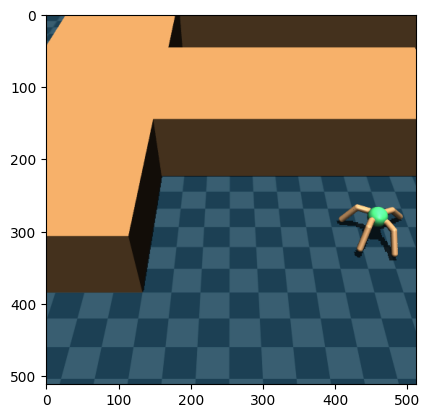

In [203]:
plt.imshow(imgs[23])